In [26]:
# Code for analysis of gDNA concentration curve 20210825
#import necessary toolboxes

import cv2         #openCV
import numpy as np
import tifffile    # to read stacked tiff file
import glob        # to grab all files in folder
import os          # to help move you in the correct directory
import math
from matplotlib import pyplot as plt # for plotting
from skimage import exposure        # for increasing brightness, rescales image
from PIL import Image, ImageDraw, ImageFilter # for making sharper lines in BF
import pandas as pd # for making excel sheet
import datetime


#import the following extra files which should be in the same folder as MAIN
from extract_Circles import  get_Circles, image_Prep, get_ROI, multiple_dfs, make_CV2image, determineThreshold
from inference import lam_dvv
%matplotlib inline


In [27]:
#-----Parameters for 8/24 ----------

# path to Image folder - copy absolute path of the folder
directory = r'C:\Users\LaelWentland\Global Health Labs, Inc\Digital Assay Feasibility - Data\Interns\Lael W\20210825 gDNA droplets curve\Imagesst228'
replicates = 1
noOfNegatives = 1 # just in case you have different number of negative images than regular replicates
imagingChannels = [ 'BF', 'FAM'] # list in order the image acquisition mode
showImage = 0  # 0 = no don't show, 1  = yes please show images!
saveToExcel = 1 # 0 = no don't save, 1 = yes please save to excel!
thresholdTrue = 1 # 0 = don't do the thresholding , 1 = yes please threshold
thresholds = {'FAM': 0.6} # choose threshold manually if you want, 
#if thresholds dictionary is left blank then the computer will automatically grab the last few 
# images and generate a threshold based on those
#------------------------------------

# the scale factor for how small the ROI square should be in the droplet
rects_scalefactor = 0.9

#modfiy the directory path to grab all .tif files, WILL IGNORE OTHER FILE TYPES
path = directory + '/*.tif'

#moves you to the directory so you can save there, if you want to save elsewhere you 
#can change the line below to move to the path of your chosing
os.chdir(directory)

#grabs all the file names of .tif images in folder
fileNames = glob.glob(path)
fileNames.sort()

In [28]:
#List that will store all the data on droplet locations and intensities
allImageData = []
allImages = []
allImageNames = []
allBFAdj = []
#Array that stores the number of positive droplets found
allPositive = np.array([])

# run through all images and grab image data, get the BF
for count, name in enumerate(fileNames):
    #tifffile-used to open tif images
    #image should alrady be in grey scale so no need to change to RGB space
    image = tifffile.imread(name)
    allImages.append(image)
    imageName = name[name.rindex('\\')+1:name.find('.tif')]
    allImageNames.append(imageName)
    
    # get location of brightfield in image stack
    indexBF = imagingChannels.index('BF')
    imageBF = image[:,:,indexBF]
    
    # adjust the BF image to increase contrast and move to 8 bit space
    # in order to extract the circles
    imageAdjusted = image_Prep(imageBF, 'BF', imageName, 0)
    allBFAdj.append(imageAdjusted)
    
    #extract circle info from images
    imageInfo = get_Circles(imageAdjusted, 'BF in ' + imageName, showImage)
    if imageInfo.shape == 0:
        # if you get no circles, the function should tell you but you 
        # need to stop the function
        raise Exception("No Droplets Were Detected! Check the Image Quality")
    allImageData.append(imageInfo)   


1


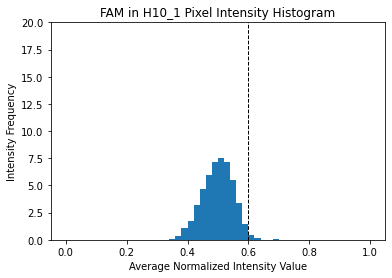

1


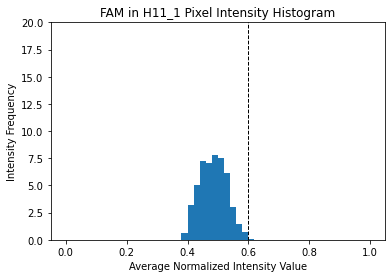

1


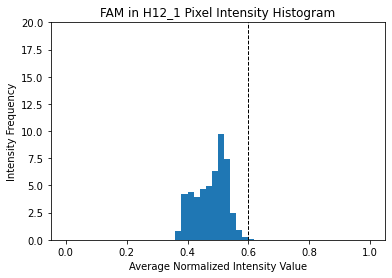

1


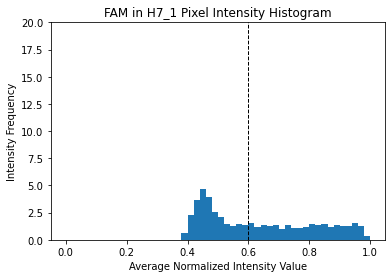

1


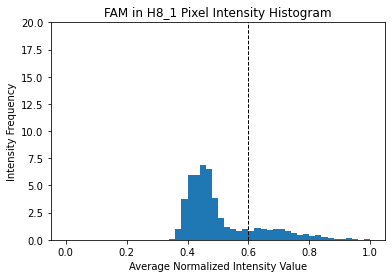

1


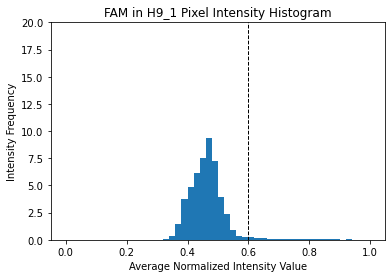

In [35]:
allPosBool = []
# look at Other channels and analyze  
if len(imagingChannels) > 1:
    
    #get indicies of things that are not BF
    nonBFIndex = [i for i in range(len(imagingChannels)) if imagingChannels[i] != 'BF']
    
    
    # establish thresholds for each channel  if no thresholds have been established
    for channel in nonBFIndex:
        #Grab the negative files and determine thresholds if has not been set
        
        if thresholdTrue == 1 and (imagingChannels[channel] in thresholds) == False:
            
            pixelData = []
            # run through the last few images, which shoulw be negative
            # generate a threshold that is 4 standard deviations from average peak
            for image, iInfo in zip(allImages[-noOfNegatives:], allImageData[-noOfNegatives:]):
                roiLoc, avgRoiVal = get_ROI(image[:,:,channel], iInfo, rects_scalefactor)
                
                avgRoiVal =  avgRoiVal.reshape((avgRoiVal.shape[0], 1))
                pixelData.append(avgRoiVal)
            
            # plug in roi average intensity of 
            avgThresh = determineThreshold(pixelData, imagingChannels[channel])
            # make threshold in threshold dictionary
            thresholds[imagingChannels[channel]] = avgThresh
            
    
    # determine the ROIs in the region and threshold data 
    for num, image in enumerate(allImages):
        allPositiveDrop = np.zeros((allImageData[num].shape[0],1))
        
        for channel in nonBFIndex:
            channelName = imagingChannels[channel] + ' in '  + allImageNames[num]
            
            #select images for analysis
            org_img = image[:,:,channel]
           
            fluorImg = org_img
            img_max = np.array(fluorImg.shape).max()
            img_min = 0
            
            # run function to  get average normalized ROI value
            roiLoc, avgRoiVal = get_ROI(fluorImg, allImageData[num], rects_scalefactor)
          
            avgRoiVal =  avgRoiVal.reshape((avgRoiVal.shape[0], 1))
            # add ROI average value to image info matrix
            allImageData[num]  = np.concatenate((allImageData[num], avgRoiVal), axis = 1)
            
            if thresholdTrue == 1:
                
                # make array of boolean for the average values
                posDropletsBool = avgRoiVal >= thresholds[imagingChannels[channel]]
                allPosBool.append(posDropletsBool)
                print(channel)
                allPositiveDrop[:,channel-1] =  posDropletsBool.ravel()
                # add data to the image info matrix
                allImageData[num]  = np.concatenate((allImageData[num], posDropletsBool), axis = 1)
                
                #plot ROI intensity histogram with cutoff line
                plt.title(channelName + " Pixel Intensity Histogram")
                plt.xlabel("Average Normalized Intensity Value")
                plt.ylabel("Intensity Frequency")
                plt.ylim(0, 20)
                y, bins, patches = plt.hist(avgRoiVal, bins = 50 , range = [0, 1], density=True)
                plt.axvline( thresholds[imagingChannels[channel]], color='k', linestyle='dashed', linewidth=1)
                plt.show()
                
            #save image info to List if this is the last image in the vertical tif stack
            if channel ==  nonBFIndex[-1]:
                # determine droplets that are positive for both fluor channels
                bothPositive = np.all( allPositiveDrop, axis = 1 )
                allImageData[num] = np.concatenate((allImageData[num], bothPositive.reshape(bothPositive.shape[0], 1)),axis = 1)


[1]


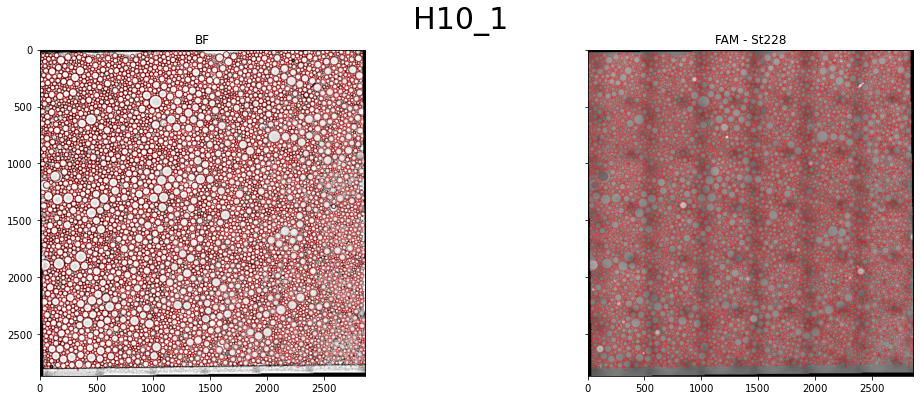

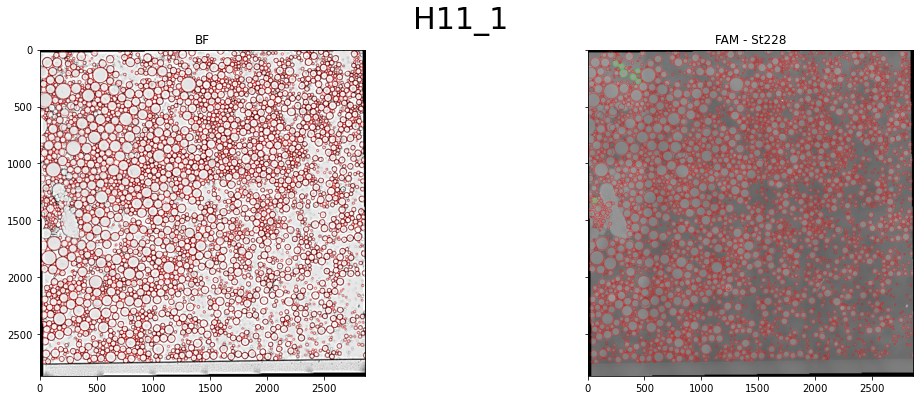

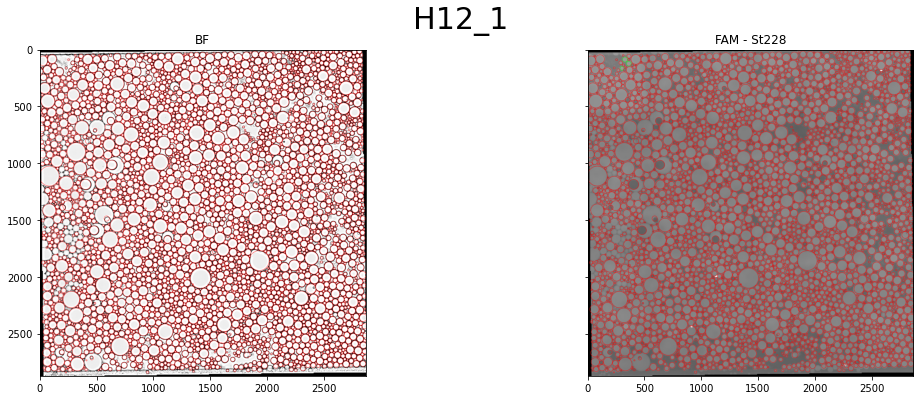

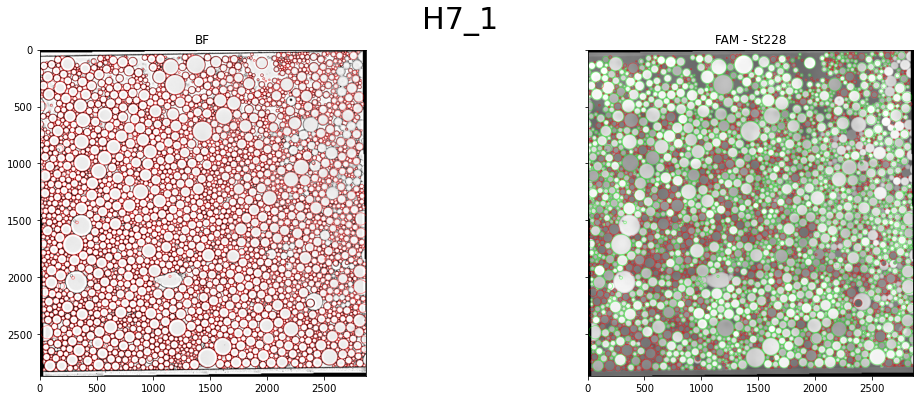

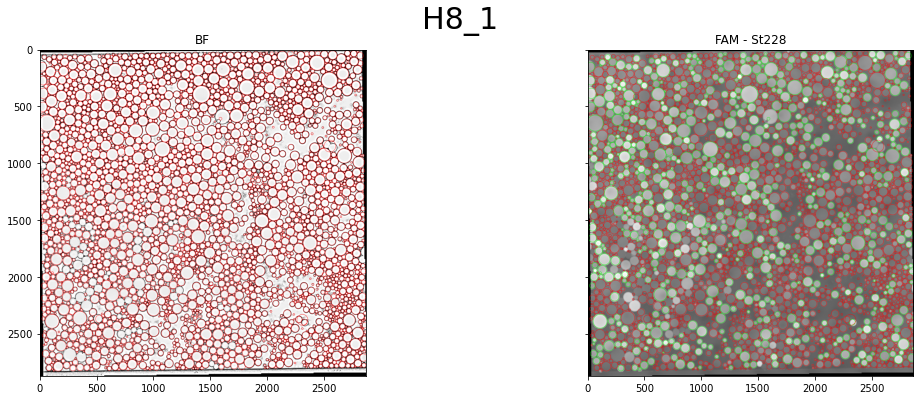

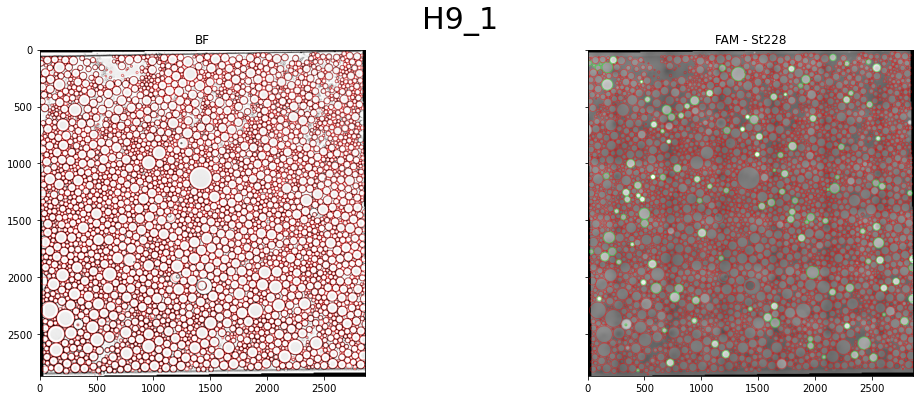

In [37]:
#this data was a little strange 

#show all the images
# i is the 0 or 1 if the droplet is positive, circs contains the (x, y, radius in pixels)
# rect is for the locaitons to draw the rectangles
for iNum, img in enumerate(allImages):
    img_rescale= exposure.rescale_intensity(img)
    img_rescale = cv2.convertScaleAbs(img_rescale, alpha =(255.0/65535.0))
    bf_overlay = np.dstack((allBFAdj[iNum],allBFAdj[iNum],allBFAdj[iNum]))
    cy5_overlay = np.dstack((img_rescale[:,:,0],img_rescale[:,:,0],img_rescale[:,:,0]))
    fam_overlay = np.dstack((img_rescale[:,:,1], img_rescale[:,:,1],img_rescale[:,:,1]))

    for f,  circ in zip(allImageData[iNum][:,6], allImageData[iNum][:,0:3]):

        # determine if the average pixel value in the rectangular roi is larger than the threshold
        if f == 1:
            fam_color = (0, 255, 0) # draw green
        else:
            fam_color = (255, 0, 0) # draw red
       
        bf_overlay = cv2.circle(bf_overlay, (int(circ[0]), int(circ[1])), int(circ[2]), (255, 0, 0), 2)
       
        fam_overlay = cv2.circle(fam_overlay, (int(circ[0]), int(circ[1])), int(circ[2]), fam_color, 2)

    fig,(ax1, ax2) = plt.subplots(1,2, sharex='col', sharey='row',figsize=(18, 6))
    fig.suptitle(allImageNames[iNum], fontsize=30)
    ax1.imshow(bf_overlay )
    ax2.imshow(fam_overlay)
    ax1.title.set_text('BF')
    ax2.title.set_text('FAM - St228')
    
volDistribution = [img[:,-3] for img in allImageData]

In [ ]:
#%%
# save data to excel if needed
# x, y, radius, radius in um, volume, pos droplet 
if saveToExcel == 1:
    dFImage = []
    imageNames = [i[i.rindex('\\')+1 : i.find('.tif')] for i in fileNames]
    # add names of channels to the columns of the sets
    
    addString = ' Normalized Intensity'
    channelEdit = [imagingChannels[i] for i in nonBFIndex]
    fluorEdit = [s + addString for s in channelEdit]
    columnName=['x', 'y', 'Radius pixel', 'Radius um', 'Volume pL']
    
    if len(imagingChannels) > 1:
        if thresholdTrue == 1:
            # edit the column names 
            posName = 'Positive Droplets'
            
            fluorEdit = [e for i in fluorEdit for e in [i, i.replace(' Normalized Intensity', " ") + posName ]]
            columnName.extend(fluorEdit)
            
            columnName.extend(['All Positive'])
        else:
            columnName.extend(fluorEdit)
    
    # convert data into data frames
    for i in allImageData: 
        df = pd.DataFrame(i,columns= columnName )
        dFImage.append(df)
    
    #save data to excel sheet
    date = datetime.datetime.now()
    date = date.strftime("%Y-%m-%d")
    exceFileName = directory + '/' + date + ' ImagingData.xlsx'
    multiple_dfs(dFImage, imageNames, 'Results', exceFileName , 1)    